# 1. base code

In [1]:
# from: https://gist.github.com/arunmallya/a6889f151483dcb348fa70523cb4f578
raw_text = """
American_Goldfinch_0062_31921.jpg -> n01531178_12730.JPEG
Indigo_Bunting_0063_11820.jpg -> n01537544_9540.JPEG
Blue_Jay_0053_62744.jpg -> n01580077_4622.JPEG
American_Goldfinch_0131_32911.jpg -> n01531178_17834.JPEG
Dark_Eyed_Junco_0057_68650.jpg -> n01534433_12777.JPEG
Indigo_Bunting_0051_12837.jpg -> n01537544_2126.JPEG
Dark_Eyed_Junco_0102_67402.jpg -> n01534433_9482.JPEG
American_Goldfinch_0012_32338.jpg -> n01531178_14394.JPEG
Laysan_Albatross_0033_658.jpg -> n02058221_16284.JPEG
Black_Footed_Albatross_0024_796089.jpg -> n02058221_6390.JPEG
Indigo_Bunting_0072_14197.jpg -> n01537544_26009.JPEG
Green_Violetear_0002_795699.jpg -> n01833805_10347.JPEG
Black_Footed_Albatross_0033_796086.jpg -> n02058221_7776.JPEG
Black_Footed_Albatross_0086_796062.jpg -> n02058221_9823.JPEG
Anna_Hummingbird_0034_56614.jpg -> n01833805_10306.JPEG
American_Goldfinch_0064_32142.jpg -> n01531178_8622.JPEG
Red_Breasted_Merganser_0068_79203.jpg -> n01855032_19954.JPEG
Blue_Jay_0033_62024.jpg -> n01580077_5373.JPEG
Ruby_Throated_Hummingbird_0090_57411.jpg -> n01833805_1561.JPEG
Indigo_Bunting_0071_11639.jpg -> n01537544_25021.JPEG
Red_Breasted_Merganser_0001_79199.jpg -> n01855032_300.JPEG
Indigo_Bunting_0060_14495.jpg -> n01537544_8418.JPEG
Laysan_Albatross_0053_543.jpg -> n02058221_10440.JPEG
American_Goldfinch_0018_32324.jpg -> n01531178_1502.JPEG
Red_Breasted_Merganser_0034_79292.jpg -> n01855032_2846.JPEG
Mallard_0067_77623.jpg -> n01847000_9239.JPEG
Red_Breasted_Merganser_0083_79562.jpg -> n01855032_8051.JPEG
Laysan_Albatross_0049_918.jpg -> n02058221_16869.JPEG
Black_Footed_Albatross_0002_55.jpg -> n02058221_29424.JPEG
Red_Breasted_Merganser_0012_79425.jpg -> n01855032_1136.JPEG
Dark_Eyed_Junco_0031_66785.jpg -> n01534433_8318.JPEG
Dark_Eyed_Junco_0037_66321.jpg -> n01534433_22902.JPEG
Indigo_Bunting_0031_13300.jpg -> n01537544_10504.JPEG
Blue_Jay_0049_63082.jpg -> n01580077_5633.JPEG
Dark_Eyed_Junco_0111_66488.jpg -> n01534433_11948.JPEG
Indigo_Bunting_0010_13000.jpg -> n01537544_16.JPEG
Red_Breasted_Merganser_0004_79232.jpg -> n01855032_6416.JPEG
Red_Breasted_Merganser_0045_79358.jpg -> n01855032_1358.JPEG
Ruby_Throated_Hummingbird_0040_57982.jpg -> n01833805_18429.JPEG
American_Goldfinch_0116_31943.jpg -> n01531178_8148.JPEG
Blue_Jay_0068_61543.jpg -> n01580077_8031.JPEG
Indigo_Bunting_0073_13933.jpg -> n01537544_2813.JPEG
Dark_Eyed_Junco_0104_67820.jpg -> n01534433_420.JPEG
""".split("\n")[1:-1]

raw_text = [it.split(" -> ")[0] for it in raw_text]


In [2]:
import os
import pandas as pd
from torchvision.datasets.folder import default_loader
from torchvision.datasets.utils import download_url
from torch.utils.data import Dataset

# found this in: https://github.com/TDeVries/cub2011_dataset/blob/master/cub2011.py
class Cub2011(Dataset):
    base_folder = 'CUB_200_2011/images'
    url = 'https://data.caltech.edu/records/65de6-vp158/files/CUB_200_2011.tgz?download=1'
    filename = 'CUB_200_2011.tgz'
    tgz_md5 = '97eceeb196236b17998738112f37df78'

    def __init__(self, root, train=True, transform=None, loader=default_loader, download=True):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.loader = default_loader
        self.train = train

        if download:
            self._download()

        if not self._check_integrity():
           raise RuntimeError('Dataset not found or corrupted.' + ' You can use download=True to download it')


    def _load_metadata(self, overlap_to_train=True):
        images = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'images.txt'), sep=' ',
                             names=['img_id', 'filepath'])
        image_class_labels = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'image_class_labels.txt'),
                                         sep=' ', names=['img_id', 'target'])
        train_test_split = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'train_test_split.txt'),
                                       sep=' ', names=['img_id', 'is_training_img'])

        if overlap_to_train: # transform all overlap to train data
            images[["dir", "file"]] = images["filepath"].str.split("/", expand=True)
            overlap_files = set(raw_text)
            overlap_df = pd.DataFrame(overlap_files, columns=['file'])
            overlap_df = overlap_df.assign(is_overlap=1).merge(images[["file", "img_id"]], on='file', how="inner")

            train_test_split = train_test_split.merge(overlap_df[["img_id", "is_overlap"]], on='img_id', how="left").fillna(0)
            train_test_split['is_overlap'] = train_test_split['is_overlap'].astype(int)
            train_test_split["is_training_img"] = train_test_split["is_training_img"] | train_test_split["is_overlap"]

            train_test_split = train_test_split[["img_id", "is_training_img"]]
            images = images[["img_id", "filepath"]]

        data = images.merge(image_class_labels, on='img_id')
        self.data = data.merge(train_test_split, on='img_id')

        if self.train:
            self.data = self.data[self.data.is_training_img == 1]
        else:
            self.data = self.data[self.data.is_training_img == 0]

    def _check_integrity(self):
        try:
            self._load_metadata()
        except Exception:
            return False

        for index, row in self.data.iterrows():
            filepath = os.path.join(self.root, self.base_folder, row.filepath)
            if not os.path.isfile(filepath):
                print(filepath)
                return False
        return True

    def _download(self):
        import tarfile

        if self._check_integrity():
            print('Files already downloaded and verified')
            return

        download_url(self.url, self.root, self.filename, self.tgz_md5)

        with tarfile.open(os.path.join(self.root, self.filename), "r:gz") as tar:
            tar.extractall(path=self.root)


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        path = os.path.join(self.root, self.base_folder, sample.filepath)
        target = sample.target - 1  # Targets start at 1 by default, so shift to 0
        img = self.loader(path)

        if self.transform is not None:
            img = self.transform(img)

        return img, target

In [3]:
from torchvision import transforms
from torch.utils.data import DataLoader
import os

mean = [0.48235, 0.45882, 0.40784]
std=[0.00392156862745098, 0.00392156862745098, 0.00392156862745098]

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size=(256, 256)),
        #transforms.RandomRotation(degrees=(-10, 10)),
        transforms.CenterCrop(size=224),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=(256, 256)),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]),
}

data_sets = {
    x: Cub2011(os.path.abspath("./data"), train=x=='train', transform=data_transforms[x] ) for x in ['train', 'test']
}

data_loaders = {
    'train': DataLoader(data_sets['train'], batch_size=20, shuffle=True),
    'test': DataLoader(data_sets['test']),
}


100%|██████████| 1150585339/1150585339 [01:14<00:00, 15486488.16it/s]


Files already downloaded and verified


In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

In [5]:
dataset_sizes = {x: len(data_sets[x]) for x in ['train', 'test']}


# 2. demo model

In [6]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [7]:
# Generic function to train a model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Copy weights
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history only if in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
# Generic function to display predictions for a few images
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(2, num_images//2, images_so_far)
                ax.axis('off')
                ax.set_title('pred/true: {}/{}'.format(preds[j], labels[j]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [9]:
model = models.resnet18(pretrained=True)

# Size of input vector to fully connected layer
num_ftrs = model.fc.in_features # 512

# Replace fully connected layer
model.fc = nn.Linear(num_ftrs, 200)

print(model.fc)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 133MB/s]


Linear(in_features=512, out_features=200, bias=True)


In [10]:
# Freeze all layers (i.e., disable training)
for param in model.parameters():
    param.requires_grad = False

# Unfreeze final layer (named fc)
for param in model.fc.parameters():
    param.requires_grad = True

# Put the model on the GPU
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [11]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 3.9824 Acc: 0.1762
test Loss: 2.6745 Acc: 0.3803

Epoch 1/4
----------
train Loss: 2.0472 Acc: 0.5118
test Loss: 2.0858 Acc: 0.4735

Epoch 2/4
----------
train Loss: 1.4250 Acc: 0.6505
test Loss: 1.9359 Acc: 0.5010

Epoch 3/4
----------
train Loss: 1.1164 Acc: 0.7214
test Loss: 1.8826 Acc: 0.5150

Epoch 4/4
----------
train Loss: 0.9118 Acc: 0.7706
test Loss: 1.7738 Acc: 0.5316

Training complete in 7m 49s
Best val Acc: 0.531560


In [12]:
# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

In [13]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 2.4714 Acc: 0.3898
test Loss: 2.6771 Acc: 0.3672

Epoch 1/4
----------
train Loss: 0.8009 Acc: 0.7818
test Loss: 1.3125 Acc: 0.6477

Epoch 2/4
----------
train Loss: 0.4332 Acc: 0.8993
test Loss: 1.2518 Acc: 0.6616

Epoch 3/4
----------
train Loss: 0.2851 Acc: 0.9460
test Loss: 1.2340 Acc: 0.6630

Epoch 4/4
----------
train Loss: 0.2049 Acc: 0.9747
test Loss: 1.2271 Acc: 0.6660

Training complete in 8m 30s
Best val Acc: 0.665971


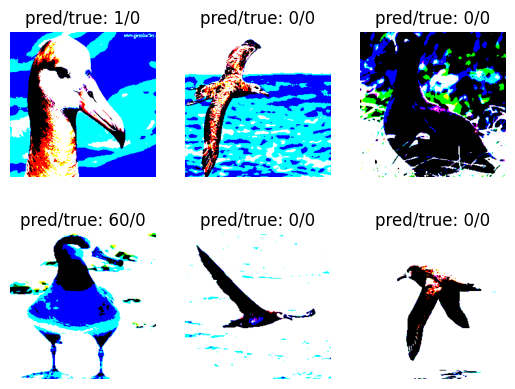

In [14]:
visualize_model(model)